In [2]:
import collections
import warnings

import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt 

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util import nest
from tensorflow.python.keras import backend
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.utils import generic_utils

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import style

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Just copypasting classes, for comments on classes see "classes and experiments" jupyter notebook

In [3]:
class NetNetCell(keras.layers.Layer):
    def __init__(self, shape, num_axons, ax_activation='relu', d_activation='relu', **kwargs):
        super(NetNetCell, self).__init__(**kwargs)

        self.shape = shape 
        self.num_axons = num_axons
        self.ax_activation = keras.activations.get(ax_activation)
        self.d_activation = keras.activations.get(d_activation)
        self.num_layers = len(self.shape)
        self.layers = [keras.layers.Dense(self.shape[i], activation=self.d_activation, trainable=True) for i in range(self.num_layers)]
        self.axon = keras.layers.Dense(self.num_axons, activation=self.d_activation, trainable=True)


        def build(self, input_shape):

            if isinstance(input_shape, list):
                input_shape = input_shape[0]
            for lay in range(num_layers):
                if isinstance(lay, keras.layers.Layer) and not lay.built:
                    with backend.name_scope(lay.name):
                        lay.build(input_shape)
                        lay.built = True
                if getattr(lay, 'output_size', None) is not None:
                    output_dim = lay.output_size
                elif _is_multiple_state(lay.state_size):
                    output_dim = lay.state_size[0]
                else:
                    output_dim = lay.state_size
                input_shape = tuple([input_shape[0]] + tensor_shape.TensorShape(output_dim).as_list())
            self.built = True

    
    @property
    def output_size(self):
        return self.num_axons
        
    @tf.function
    def call(self, x):
        for lay in self.layers:
            x = lay(x)
        x = self.axon(x)
        return x

In [4]:
class NetNetLayer(keras.layers.Layer):
    def __init__(self, cells, **kwargs):
        super(NetNetLayer, self).__init__(**kwargs)
        self.cells = cells

    @property
    def output_size(self):
        return (self.cells[0].output_size * len(self.cells))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        for cell in self.cells:
            if isinstance(cell, keras.layers.Layer) and not cell.built:
                with backend.name_scope(cell.name):
                    cell.build(input_shape)
                    cell.built = True
            if getattr(cell, 'output_size', None) is not None:
                output_dim = cell.output_size
            elif _is_multiple_state(cell.state_size):
                output_dim = cell.state_size[0]
            else:
                output_dim = cell.state_size
            input_shape = tuple([input_shape[0]] + tensor_shape.TensorShape(output_dim).as_list())
        self.built = True

    @tf.function
    def call(self, inputs):
        nested_outputs = []
        for cell in self.cells:
            x = cell(inputs)
            nested_outputs.append(x)
        return nest.pack_sequence_as(self.output_size, nest.flatten(tf.concat(nested_outputs, axis=1)))

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
val_size = .1 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=val_size, stratify=y_train_full)

In [7]:
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

In [8]:
n_classes=10

y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

## LeNet-5

In [8]:
keras.backend.clear_session()

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Reshape(target_shape=(28,28,1))(inputs)
x = keras.layers.Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu', input_shape=(28, 28, 1))(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x) # valid: no padding
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(120, activation='relu')(x)
x = keras.layers.Dense(84, activation='relu')(x)
out = keras.layers.Dense(10, activation='softmax')(x)

In [9]:
LN5 = keras.Model(inputs=inputs, outputs=out)

In [10]:
LN5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0     

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [13]:
LN5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
LN5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0     

In [15]:
LN5_history = LN5.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Epoch 1/30
1688/1688 [==============================] - 14s 4ms/step - loss: 0.4740 - accuracy: 0.8263 - val_loss: 0.4062 - val_accuracy: 0.8528
Epoch 2/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3686 - accuracy: 0.8679 - val_loss: 0.3560 - val_accuracy: 0.8765
Epoch 3/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3526 - accuracy: 0.8752 - val_loss: 0.3760 - val_accuracy: 0.8730
Epoch 4/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3428 - accuracy: 0.8800 - val_loss: 0.3926 - val_accuracy: 0.8668
Epoch 5/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3338 - accuracy: 0.8818 - val_loss: 0.4348 - val_accuracy: 0.8603
Epoch 6/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3300 - accuracy: 0.8845 - val_loss: 0.4067 - val_accuracy: 0.8637
Epoch 7/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3251 - accuracy: 0.8846 - val_loss: 0.4169 - val_accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

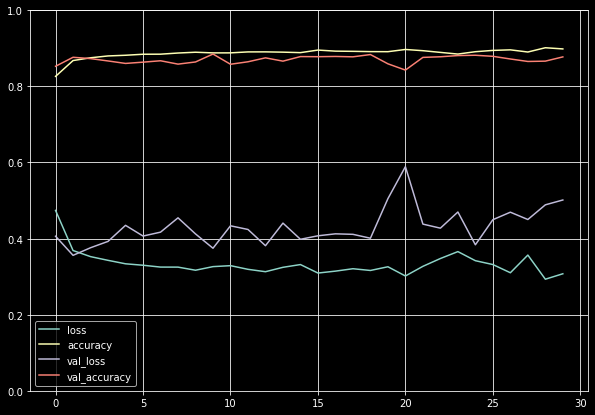

In [16]:
pd.DataFrame(LN5_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [17]:
#evaluate model on the test set
test_loss, test_acc = LN5.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.4954 - accuracy: 0.8781

Test Loss:	 0.4954385757446289
Test Accuracy:	 0.8780999779701233


In [18]:
y_pred = LN5.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

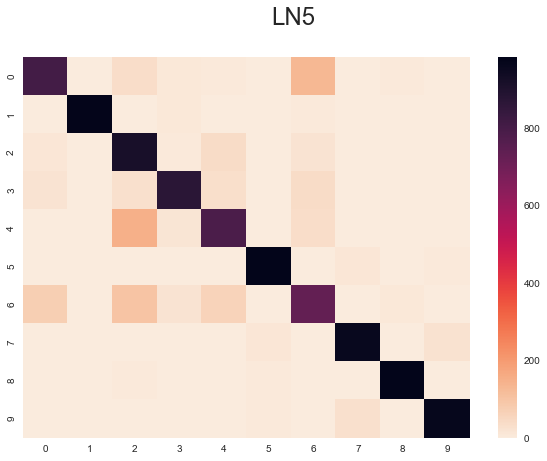

In [18]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('LN5', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

## NNN LeNet-5  (a)

In [9]:
keras.backend.clear_session()

neurons_1 = [NetNetCell(shape=[6,6,4], num_axons=1) for _ in range(120)]
neurons_2 = [NetNetCell(shape=[4,4,3], num_axons=1) for _ in range(84)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Reshape(target_shape=(28,28,1))(inputs)
x = keras.layers.Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu', input_shape=(28, 28, 1))(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x) # valid: no padding
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
x = keras.layers.Flatten()(x)
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

In [25]:
LNNN5 = keras.Model(inputs=[inputs], outputs=[out])

In [26]:
opt = keras.optimizers.Adam(learning_rate=0.01)
LNNN5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
LNNN5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0     

In [27]:
LNNN5_history = LNNN5.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Epoch 1/30
1688/1688 [==============================] - 497s 276ms/step - loss: 0.5139 - accuracy: 0.8079 - val_loss: 0.4357 - val_accuracy: 0.8395
Epoch 2/30
1688/1688 [==============================] - 466s 276ms/step - loss: 0.3662 - accuracy: 0.8668 - val_loss: 0.3790 - val_accuracy: 0.8695
Epoch 3/30
1688/1688 [==============================] - 460s 272ms/step - loss: 0.3288 - accuracy: 0.8805 - val_loss: 0.3635 - val_accuracy: 0.8668
Epoch 4/30
1688/1688 [==============================] - 457s 270ms/step - loss: 0.3223 - accuracy: 0.8839 - val_loss: 0.4123 - val_accuracy: 0.8553
Epoch 5/30
1688/1688 [==============================] - 464s 275ms/step - loss: 0.3105 - accuracy: 0.8886 - val_loss: 0.3672 - val_accuracy: 0.8655
Epoch 6/30
1688/1688 [==============================] - 474s 281ms/step - loss: 0.3422 - accuracy: 0.8770 - val_loss: 0.3643 - val_accuracy: 0.8717
Epoch 7/30
1688/1688 [==============================] - 474s 281ms/step - loss: 0.4117 - accuracy: 0.8557 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

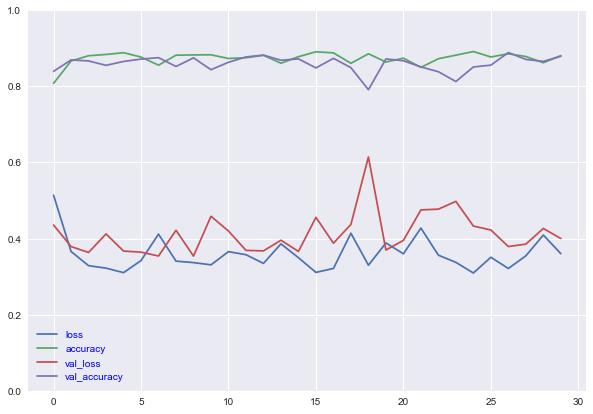

In [28]:
pd.DataFrame(LNNN5_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [29]:
#evaluate model on the test set
test_loss, test_acc = LNNN5.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 60s 191ms/step - loss: 0.3926 - accuracy: 0.8790

Test Loss:	 0.3925628066062927
Test Accuracy:	 0.8790000081062317


In [30]:
y_pred = LNNN5.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

<AxesSubplot:>

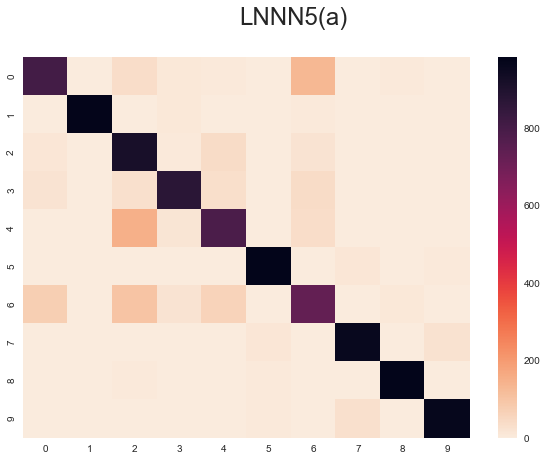

In [19]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('LNNN5(a)', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')

### NNN LeNet-5 (b)

In [10]:
keras.backend.clear_session()

neurons_1 = [NetNetCell(shape=[30,30,20,10], num_axons=1) for _ in range(120)]
neurons_2 = [NetNetCell(shape=[20,20,15,8], num_axons=1) for _ in range(84)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Reshape(target_shape=(28,28,1))(inputs)
x = keras.layers.Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu', input_shape=(28, 28, 1))(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x) # valid: no padding
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
x = keras.layers.Flatten()(x)
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

In [11]:
LNNN5second = keras.Model(inputs=[inputs], outputs=[out])

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.001)
LNNN5second.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
LNNN5second.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0     

In [13]:
LNNN5second_history = LNNN5second.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Epoch 1/30
1688/1688 [==============================] - 594s 321ms/step - loss: 0.4958 - accuracy: 0.8167 - val_loss: 0.3862 - val_accuracy: 0.8588
Epoch 2/30
1688/1688 [==============================] - 537s 318ms/step - loss: 0.3204 - accuracy: 0.8829 - val_loss: 0.3005 - val_accuracy: 0.8882
Epoch 3/30
1688/1688 [==============================] - 538s 319ms/step - loss: 0.2770 - accuracy: 0.8976 - val_loss: 0.2790 - val_accuracy: 0.8933
Epoch 4/30
1688/1688 [==============================] - 540s 320ms/step - loss: 0.2467 - accuracy: 0.9085 - val_loss: 0.2779 - val_accuracy: 0.8992
Epoch 5/30
1688/1688 [==============================] - 542s 321ms/step - loss: 0.2225 - accuracy: 0.9175 - val_loss: 0.2543 - val_accuracy: 0.9038
Epoch 6/30
1688/1688 [==============================] - 541s 321ms/step - loss: 0.2006 - accuracy: 0.9239 - val_loss: 0.2576 - val_accuracy: 0.9047
Epoch 7/30
1688/1688 [==============================] - 539s 319ms/step - loss: 0.1817 - accuracy: 0.9318 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

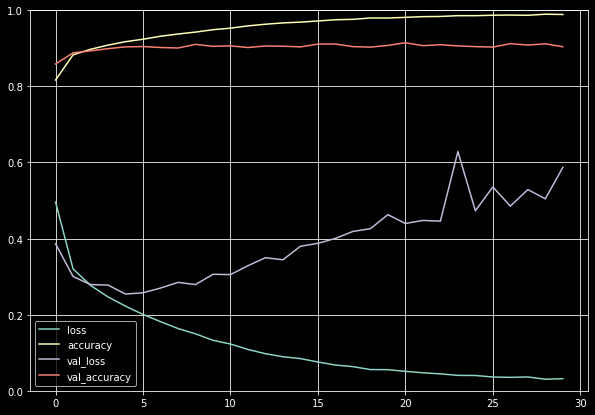

In [14]:
pd.DataFrame(LNNN5second_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [15]:
test_loss, test_acc = LNNN5second.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 39s 125ms/step - loss: 0.6479 - accuracy: 0.8985

Test Loss:	 0.6479474902153015
Test Accuracy:	 0.8985000252723694


In [16]:
y_pred = LNNN5second.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

<AxesSubplot:>

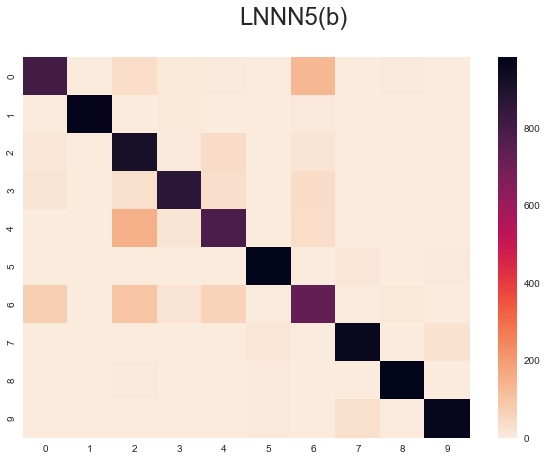

In [20]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('LNNN5(b)', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')